[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adaptive-intelligent-robotics/QDax/blob/main/examples/mapelites.ipynb)

# Optimizing with MAP-Elites in JAX

This notebook shows how to use QDax to find diverse and performing controllers in MDPs with [MAP-Elites](https://arxiv.org/abs/1504.04909).
It can be run locally or on Google Colab. We recommend to use a GPU. This notebook will show:

- how to define the problem
- how to create an emitter
- how to create a Map-elites instance
- which functions must be defined before training
- how to launch a certain number of training steps
- how to visualise the optimization process
- how to save/load a repertoire

## Installation

You will need Python 3.11 or later, and a working JAX installation. For example, you can install JAX with:

In [1]:
%pip install -U "jax"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Then, install QDax from the GitHub repository (to get the latest updates):

In [ ]:
%pip install -U "git+https://github.com/adaptive-intelligent-robotics/QDax.git#egg=qdax[examples]"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
os.environ['JAX_PLATFORMS'] = 'cpu'

from IPython.display import clear_output
import functools
import time

import jax
import jax.numpy as jnp

from qdax.core.map_elites import MAPElites
from qdax.core.containers.mapelites_repertoire import compute_cvt_centroids, MapElitesRepertoire
import qdax.tasks.brax as environments
from qdax.tasks.brax.env_creators import scoring_function_brax_envs as scoring_function
from qdax.core.neuroevolution.buffers.buffer import QDTransition
from qdax.core.neuroevolution.networks.networks import MLP
from qdax.core.emitters.mutation_operators import isoline_variation
from qdax.core.emitters.standard_emitters import MixingEmitter
from qdax.utils.plotting import plot_map_elites_results

from qdax.utils.metrics import CSVLogger, default_qd_metrics

from jax.flatten_util import ravel_pytree

from IPython.display import HTML
from brax.io import html

Failed to import warp: No module named 'warp'
Failed to import mujoco_warp: No module named 'warp'


In [4]:
#@title QD Training Definitions Fields
#@markdown ---
batch_size = 100 #@param {type:"number"}
env_name = 'walker2d_uni'#@param['ant_uni', 'hopper_uni', 'walker2d_uni', 'halfcheetah_uni', 'humanoid_uni', 'ant_omni', 'humanoid_omni']
episode_length = 100 #@param {type:"integer"}
num_iterations = 1000 #@param {type:"integer"}
seed = 42 #@param {type:"integer"}
policy_hidden_layer_sizes = (64, 64) #@param {type:"raw"}
iso_sigma = 0.005 #@param {type:"number"}
line_sigma = 0.05 #@param {type:"number"}
num_init_cvt_samples = 50000 #@param {type:"integer"}
num_centroids = 1024 #@param {type:"integer"}
min_descriptor = 0. #@param {type:"number"}
max_descriptor = 1.0 #@param {type:"number"}
#@markdown ---

## Init environment, policy, population params, init states of the env

Define the environment in which the policies will be trained. In this notebook, we focus on controllers learning to move a robot in a physical simulation. We also define the shared policy, that every individual in the population will use. Once the policy is defined, all individuals are defined by their parameters, that corresponds to their genotype.

In [5]:
print(jax.devices())

[CpuDevice(id=0)]


In [6]:
# Init environment
env = environments.create(env_name, episode_length=episode_length)
reset_fn = jax.jit(env.reset)

# Init a random key
key = jax.random.key(seed)

# Init policy network
policy_layer_sizes = policy_hidden_layer_sizes + (env.action_size,)
policy_network = MLP(
    layer_sizes=policy_layer_sizes,
    kernel_init=jax.nn.initializers.lecun_uniform(),
    final_activation=jnp.tanh,
)

# Init population of controllers
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num=batch_size)
fake_batch = jnp.zeros(shape=(batch_size, env.observation_size))
init_variables = jax.vmap(policy_network.init)(keys, fake_batch)

/Users/briancf/Desktop/source/EvoAlgsAndSwarm/lib-qdax/QDax/.venv/lib/python3.12/site-packages/brax/io/mjcf.py:480: UserWarning: Brax System, piplines and environments are not actively being maintained. Please see MJX for a well maintained JAX-based physics engine: https://github.com/google-deepmind/mujoco/tree/main/mjx. For a host of environments that use MJX, see: https://github.com/google-deepmind/mujoco_playground.
  warnings.warn(


## Define the way the policy interacts with the env

Now that the environment and policy has been defined, it is necessary to define a function that describes how the policy must be used to interact with the environment and to store transition data.

In [7]:
# Define the function to play a step with the policy in the environment
def play_step_fn(
    env_state,
    policy_params,
    key,
):
    """
    Play an environment step and return the updated state and the transition.
    """

    actions = policy_network.apply(policy_params, env_state.obs)

    state_desc = env_state.info["state_descriptor"]
    next_state = env.step(env_state, actions)

    transition = QDTransition(
        obs=env_state.obs,
        next_obs=next_state.obs,
        rewards=next_state.reward,
        dones=next_state.done,
        actions=actions,
        truncations=next_state.info["truncation"],
        state_desc=state_desc,
        next_state_desc=next_state.info["state_descriptor"],
    )

    return next_state, policy_params, key, transition

## Define the scoring function and the way metrics are computed

The scoring function is used in the evaluation step to determine the fitness and descriptor of each individual.

In [8]:
# Prepare the scoring function
descriptor_extraction_fn = environments.descriptor_extractor[env_name]
scoring_fn = functools.partial(
    scoring_function,
    episode_length=episode_length,
    play_reset_fn=reset_fn,
    play_step_fn=play_step_fn,
    descriptor_extractor=descriptor_extraction_fn,
)

# Get minimum reward value to make sure qd_score are positive
reward_offset = environments.reward_offset[env_name]

# Define a metrics function
metrics_function = functools.partial(
    default_qd_metrics,
    qd_offset=reward_offset * episode_length,
)

## Define the emitter

The emitter is used to evolve the population at each mutation step.

In [9]:
# Define emitter
variation_fn = functools.partial(
    isoline_variation, iso_sigma=iso_sigma, line_sigma=line_sigma
)

mixing_emitter = MixingEmitter(
    mutation_fn=None,
    variation_fn=variation_fn,
    variation_percentage=1.0,
    batch_size=batch_size
)

## Instantiate and initialise the MAP Elites algorithm

In [10]:
# Instantiate MAP-Elites
map_elites = MAPElites(
    scoring_function=scoring_fn,
    emitter=mixing_emitter,
    metrics_function=metrics_function,
)

# Compute the centroids
key, subkey = jax.random.split(key)
centroids = compute_cvt_centroids(
    num_descriptors=env.descriptor_length,
    num_init_cvt_samples=num_init_cvt_samples,
    num_centroids=num_centroids,
    minval=min_descriptor,
    maxval=max_descriptor,
    key=subkey,
)

# Compute initial repertoire and emitter state
key, subkey = jax.random.split(key)
repertoire, emitter_state, init_metrics = map_elites.init(init_variables, centroids, subkey)

## Launch MAP-Elites iterations

In [11]:
log_period = 10
num_loops = num_iterations // log_period

# Initialize metrics
metrics = {key: jnp.array([]) for key in ["iteration", "qd_score", "coverage", "max_fitness", "time"]}

# Set up init metrics
init_metrics = jax.tree.map(lambda x: jnp.array([x]) if x.shape == () else x, init_metrics)
init_metrics["iteration"] = jnp.array([0], dtype=jnp.int32)
init_metrics["time"] = jnp.array([0.0])  # No time recorded for initialization

# Convert init_metrics to match the metrics dictionary structure
metrics = jax.tree.map(lambda metric, init_metric: jnp.concatenate([metric, init_metric], axis=0), metrics, init_metrics)

# Initialize CSV logger
csv_logger = CSVLogger(
    "mapelites-logs.csv",
    header=list(metrics.keys())
)

# Log initial metrics
csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

# Main loop
map_elites_scan_update = map_elites.scan_update
for i in range(num_loops):
    start_time = time.time()
    (
        repertoire,
        emitter_state,
        key,
    ), current_metrics = jax.lax.scan(
        map_elites_scan_update,
        (repertoire, emitter_state, key),
        (),
        length=log_period,
    )
    timelapse = time.time() - start_time

    # Metrics
    current_metrics["iteration"] = jnp.arange(1+log_period*i, 1+log_period*(i+1), dtype=jnp.int32)
    current_metrics["time"] = jnp.repeat(timelapse, log_period)
    metrics = jax.tree.map(lambda metric, current_metric: jnp.concatenate([metric, current_metric], axis=0), metrics, current_metrics)

    # Log
    csv_logger.log(jax.tree.map(lambda x: x[-1], metrics))

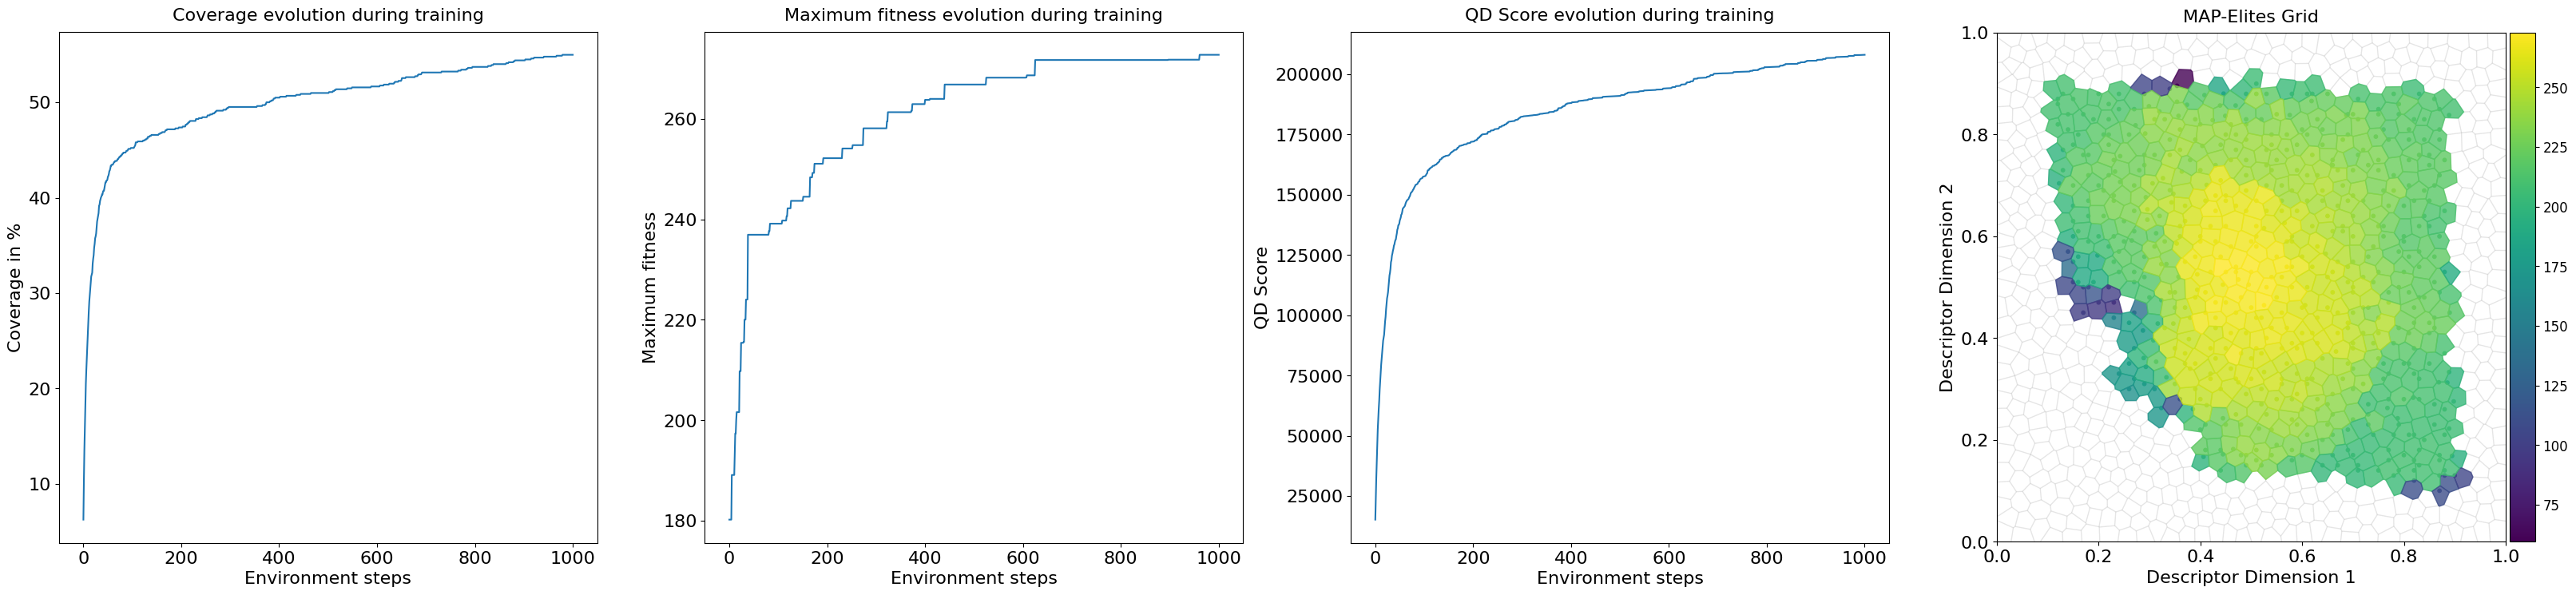

In [12]:
#@title Visualization

# Create the x-axis array
env_steps = metrics["iteration"]

%matplotlib inline
# Create the plots and the grid
fig, axes = plot_map_elites_results(env_steps=env_steps, metrics=metrics, repertoire=repertoire, min_descriptor=min_descriptor, max_descriptor=max_descriptor)

## Get the best individual of the repertoire

In [13]:
best_idx = jnp.argmax(repertoire.fitnesses)
best_fitness = jnp.max(repertoire.fitnesses)
best_descriptor = repertoire.descriptors[best_idx]

In [14]:
print(
    f"Best fitness in the repertoire: {best_fitness:.2f}\n",
    f"Descriptor of the best individual in the repertoire: {best_descriptor}\n",
    f"Index in the repertoire of this individual: {best_idx}\n"
)

Best fitness in the repertoire: 272.78
 Descriptor of the best individual in the repertoire: [0.45 0.53]
 Index in the repertoire of this individual: 501



In [15]:
my_params = jax.tree.map(
    lambda x: x[best_idx],
    repertoire.genotypes
)

## Play some steps in the environment

In [16]:
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(policy_network.apply)

In [17]:
rollout = []
key, subkey = jax.random.split(key)
state = jit_env_reset(rng=subkey)
list_pipeline_states = []
while not state.done:
    rollout.append(state)
    action = jit_inference_fn(my_params, state.obs)
    state = jit_env_step(state, action)
    list_pipeline_states.append(state.pipeline_state)

print(f"The trajectory of this individual contains {len(rollout)} transitions.")

The trajectory of this individual contains 100 transitions.


In [18]:
def save_rollout_html(env, pipeline_env_list, file_name: str):
  sys = env.sys.tree_replace({'opt.timestep': env.dt})
  rollout_html = html.render(sys, pipeline_env_list)
  with open(file_name, 'w') as f:
      f.write(rollout_html)


save_rollout_html(env, list_pipeline_states, "rollout.html")